In [1]:
#FER2013のモデルを転移学習に活用してみる
#データオーグメンテーションとか出来そうなこと色々

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import glob
import os
import random
import urllib
from tensorflow.keras import layers
import tensorflow_io as tfio


#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))
#import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

import pydot
import pydotplus
import graphviz
from keras.utils.vis_utils import plot_model

In [2]:
'''画像データの読み込み'''
#【フォルダ内のjpgファイルを一覧表示】
data_folder = pathlib.Path("C:/Users/5010173/AI/datasets/face_AIST")
img_size = 48

all_image_paths = list(data_folder.glob('**/*.jpg'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)

#フォルダ内のjpgファイルのテンソルへのデコードの関数化
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image[150:650,50:550], [img_size, img_size])
  image = tfio.experimental.color.rgb_to_grayscale(image) #グレースケール変換
  image /= 255.0  # normalize to [0,1] range
  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)



'''ラベルデータの作成'''
#【ラベルの読み込み】　ラベルは一つずつなのか？同時に二つは無理なのか？　→　まずは一つずつ処理する
label_path = pathlib.Path("C:/Users/5010173/AI/datasets/face_AIST/FacialExpressionDB_score.csv")
df1 = pd.read_csv(label_path, encoding= "utf-8")

#複数のインデックスを指定
df2 = df1.set_index(['axis', 'Model', 'FaceAngle'])

#【画像のパスの中から、Personと感情とFaceAngleを抽出する】
all_image_paths_person = []
all_image_paths_info = []
path_base = 'face_AIST'
path_base2 = 'jpg'

for i in range(len(all_image_paths)):
    idx = all_image_paths[i].find(path_base)
    idx2 = all_image_paths[i].find(path_base2)
    all_image_paths_person.append(all_image_paths[i][idx+10:idx+13])
    all_image_paths_info.append(all_image_paths[i][idx+18:idx2-1])
del i,idx,idx2

all_image_paths_FaceAngle = []
all_image_paths_Emotion = []
path_base = '_'

for i in range(len(all_image_paths)):
    idx = all_image_paths_info[i].find(path_base)
    all_image_paths_Emotion.append(all_image_paths_info[i][:idx])
    all_image_paths_FaceAngle.append(all_image_paths_info[i][idx+1:])
del i,idx

#リスト内の0をfrontに置換
all_image_paths_FaceAngle = ['front' if s=='0' else s for s in all_image_paths_FaceAngle]

#【データフレームdf3の項目名を変更】
df3 = df2.rename(index = str.lower)  #インデックスを小文字に
df3.rename(columns = {'Anger_cl':'angcl', 'Anger_op':'angop', 'Disgust_cl':'discl', \
    'Disgust_op':'disop', 'Excitement':'exc', 'Fear':'fea', 'Happiness':'hap', \
        'Neutral':'neu', 'Relaxation':'rel', 'Sadness':'sad', 'Sleepiness':'sle', \
            'Surprise':'sur'}, inplace = True) 

#【データフレームdf3から、各画像のラベルを抽出してリストに格納】
paths_Valence = []
paths_Arousal = []
for i in range(len(all_image_paths)):
    paths_Valence.append(df3.loc[('valence',all_image_paths_person[i], all_image_paths_FaceAngle[i]),all_image_paths_Emotion[i]])
    paths_Arousal.append(df3.loc[('arousal',all_image_paths_person[i], all_image_paths_FaceAngle[i]),all_image_paths_Emotion[i]])
del i
#このように、教師データとラベルをそれぞれ順序一致させてリストに入れれば、データセットが出来る



'''画像のデータセット化'''
#画像データセットはadarray型にする
#おそらくもっと良い読み込み方あるけど、いったんこのやり方で。
images = []
for i in range(len(all_image_paths)):
   images.append(load_and_preprocess_image(all_image_paths[i]))
ds_Img_raw = np.array(images)  #画像データセット

ds_label_V_raw = np.array(paths_Valence)  #Valenceラベルデータセット
ds_label_A_raw = np.array(paths_Arousal)  #Arousalラベルデータセット

#訓練データとテストデータに分割（検証用データはモデル内で定義）
ds_Img_train, ds_Img_test = np.split(ds_Img_raw,[400],0)
ds_label_V_train, ds_label_V_test = np.split(ds_label_V_raw,[400],0)
ds_label_A_train, ds_label_A_test = np.split(ds_label_A_raw,[400],0)

In [3]:
#Data Augumentation

train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)
train_generator_V = train_datagen.flow(ds_Img_train,
                                        y = ds_label_V_train,
                                        batch_size = 64,
                                        save_to_dir = 'data_augumentation'
                                    )
validation_generator_V = validation_datagen.flow(ds_Img_train,
                                                    y = ds_label_V_train,
                                                    batch_size = 64,
                                                    save_to_dir = 'data_augumentation'
                                                )
train_generator_A = train_datagen.flow(ds_Img_train,
                                        y = ds_label_A_train,
                                        batch_size = 64,
                                        save_to_dir = 'data_augumentation'
                                    )
validation_generator_A = validation_datagen.flow(ds_Img_train,
                                                    y = ds_label_A_train,
                                                    batch_size = 64,
                                                    save_to_dir = 'data_augumentation'
                                                )

In [4]:
'''
#モデルの構築
def build_model():
  model = keras.Sequential([
    layers.Flatten(input_shape=(128, 128)),
    layers.Dense(128, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()
model.summary()
'''

'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adam

model = Sequential()
#畳み込み層1
model.add(
  Conv2D(filters = 16,
               kernel_size = (3,3),
               padding = 'same',
               input_shape = (128, 128, 1),
               activation = 'relu'
               ))
#プーリング層
model.add(MaxPooling2D(pool_size = (4,4)))
#ドロップアウト
model.add(Dropout(0.5))
#畳み込み層2
model.add(
  Conv2D(filters = 32,
               kernel_size = (3,3),
               padding = 'same',
               input_shape = (32, 32, 1),
               activation = 'relu'
               ))
#プーリング層
model.add(MaxPooling2D(pool_size = (2,2)))
#ドロップアウト
model.add(Dropout(0.5))
#畳み込み層3
model.add(
  Conv2D(filters = 32,
               kernel_size = (3,3),
               padding = 'same',
               input_shape = (16, 16, 1),
               activation = 'relu'
               ))
#プーリング層
model.add(MaxPooling2D(pool_size = (2,2)))
#ドロップアウト
model.add(Dropout(0.5))
#1次元化
model.add(Flatten())  #(8,8,32)->(2042)にフラット化
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

#model.compile(
#  loss = 'sparse_categorical_crossentropy',
#         optimizer = SGD(lr=0.1),
#         metrics = ['accuracy'])

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

model.summary()

plot_model(model, show_shapes=True, show_layer_names=True)
'''

"\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D\nfrom tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adam\n\nmodel = Sequential()\n#畳み込み層1\nmodel.add(\n  Conv2D(filters = 16,\n               kernel_size = (3,3),\n               padding = 'same',\n               input_shape = (128, 128, 1),\n               activation = 'relu'\n               ))\n#プーリング層\nmodel.add(MaxPooling2D(pool_size = (4,4)))\n#ドロップアウト\nmodel.add(Dropout(0.5))\n#畳み込み層2\nmodel.add(\n  Conv2D(filters = 32,\n               kernel_size = (3,3),\n               padding = 'same',\n               input_shape = (32, 32, 1),\n               activation = 'relu'\n               ))\n#プーリング層\nmodel.add(MaxPooling2D(pool_size = (2,2)))\n#ドロップアウト\nmodel.add(Dropout(0.5))\n#畳み込み層3\nmodel.add(\n  Conv2D(filters = 32,\n               kernel_size = (3,3),\n               padding = 'same',\n               input_shape = (16, 16, 1),\n        

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

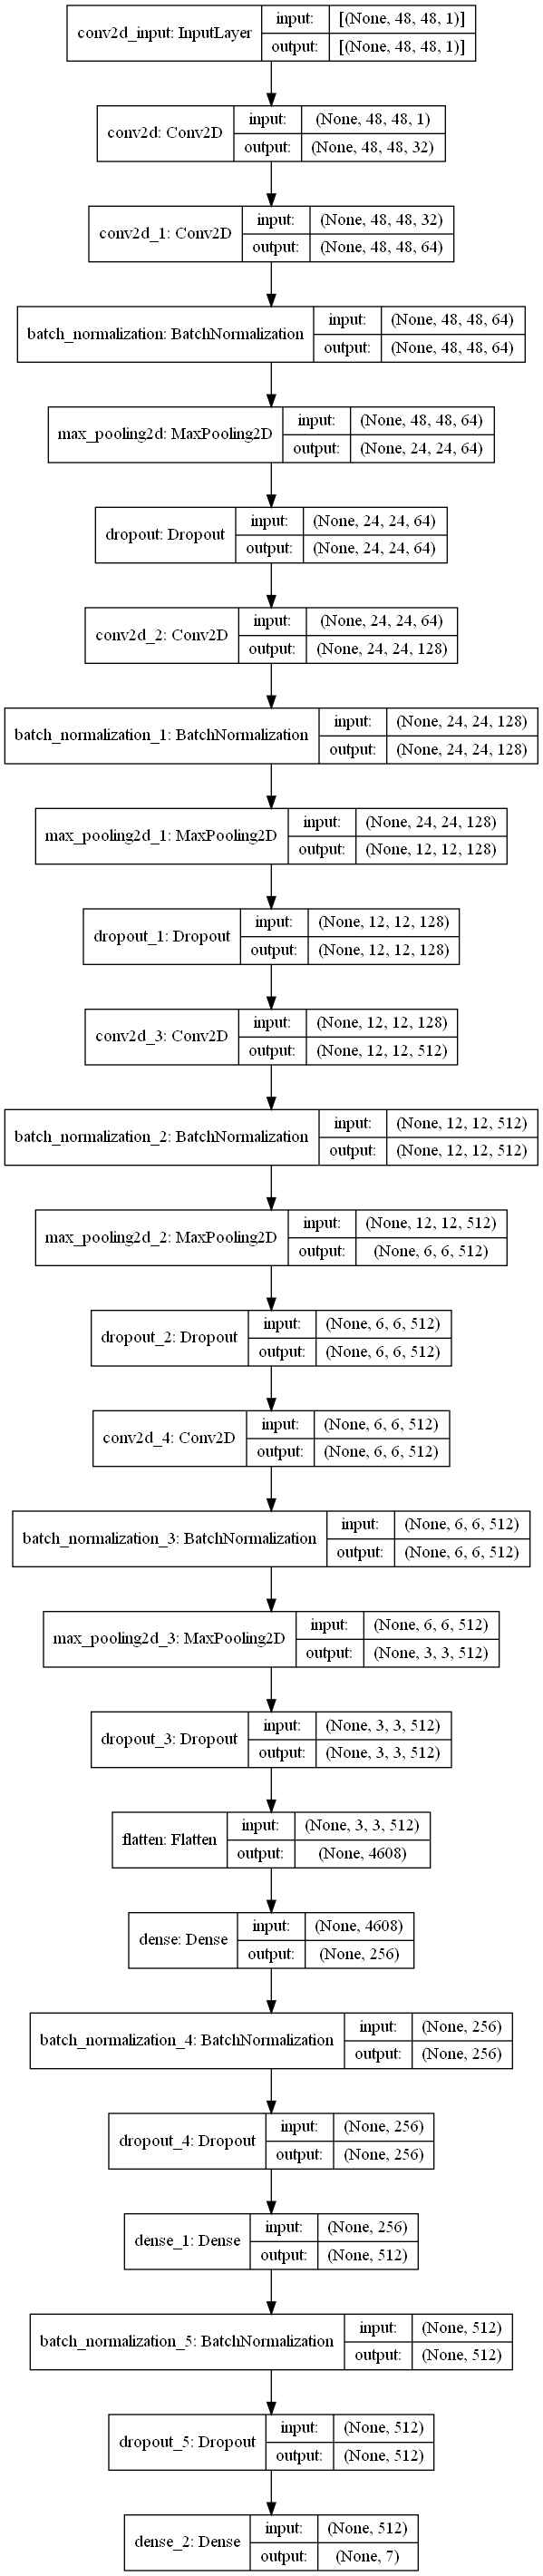

In [17]:
#モデルのロード
model = keras.models.load_model('C:/Users/5010173/venv01/main/kaggle/FER2013/model/model_optimal.h5')
model.summary()

plot_model(model, show_shapes=True, show_layer_names=True)

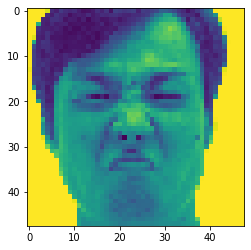

In [6]:
'''
#画像のリサイズサイズの見極め

#画像のリサイズ
image_check = image.load_img("C:/Users/5010173/AI/datasets/face_AIST/f01/f01_angcl_right45.jpg")
image_check= np.array(image_check)
plt.imshow(image_check)
print(image_check.shape)

(width, height) = (48, 48)
image_check_resize = cv2.resize(image_check[150:650,50:550], (width, height))
plt.imshow(image_check_resize)
print(image_check_resize.shape)
'''

plt.imshow(ds_Img_train[1,:])


In [18]:
#既存モデルの重みの固定
for layer in model.layers[:]:
    layer.trainable = False

model.pop()  #最終レイヤーの削除

model_tuning = tf.keras.Sequential([
    model,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(32),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1)
])

for layer in model_tuning.layers:  #重みが固定されているかの確認
	print(layer, layer.trainable)

model_tuning.summary()

plot_model(model_tuning, show_shapes=True, show_layer_names=True)

optimizer = tf.keras.optimizers.RMSprop(0.001)
model_tuning.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae', 'mse'])

<keras.engine.sequential.Sequential object at 0x0000024070BA0DF0> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000023F354E30A0> True
<keras.layers.core.Dropout object at 0x0000023E8DC716A0> True
<keras.layers.core.Dense object at 0x0000023E8DC71D00> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000023E8DC71A00> True
<keras.layers.core.Dropout object at 0x0000023E8DC713D0> True
<keras.layers.core.Dense object at 0x0000023E8DC71040> True
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 512)               4493312   
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0       

In [30]:

#モデルの訓練
#エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')
EPOCHS = 100

# patience は改善が見られるかを監視するエポック数を表すパラメーター
#これ入れるとうまく計算できなかったので、一旦このコールバックは付けない
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#Valenceの訓練
history_V = model_tuning.fit(
  train_generator_V, epochs=EPOCHS, 
  validation_data = validation_generator_V, verbose=1,
  callbacks=[PrintDot()])
  #callbacks=[early_stop, PrintDot()])

#Arousalの訓練
history_A = model_tuning.fit(
  train_generator_A, epochs=EPOCHS, 
  validation_data = validation_generator_A, verbose=1,
  callbacks=[PrintDot()])
  #callbacks=[early_stop, PrintDot()])


Epoch 1/100
7/7 [==============================] - 1s 145ms/step - loss: 5.8674 - mae: 2.0274 - mse: 5.4325 - val_loss: 4.8950 - val_mae: 1.8369 - val_mse: 4.4601

.Epoch 2/100
7/7 [==============================] - 1s 133ms/step - loss: 5.1858 - mae: 1.9049 - mse: 4.7509 - val_loss: 4.7049 - val_mae: 1.7945 - val_mse: 4.2701
.Epoch 3/100
7/7 [==============================] - 1s 158ms/step - loss: 5.1447 - mae: 1.8859 - mse: 4.7098 - val_loss: 4.8438 - val_mae: 1.8246 - val_mse: 4.4089
.Epoch 4/100
7/7 [==============================] - 1s 148ms/step - loss: 4.8507 - mae: 1.8186 - mse: 4.4158 - val_loss: 4.6617 - val_mae: 1.7865 - val_mse: 4.2269
.Epoch 5/100
7/7 [==============================] - 1s 143ms/step - loss: 5.0096 - mae: 1.8448 - mse: 4.5748 - val_loss: 4.5009 - val_mae: 1.7630 - val_mse: 4.0660
.Epoch 6/100
7/7 [==============================] - 1s 141ms/step - loss: 5.0886 - mae: 1.8799 - mse: 4.6537 - val_loss: 4.4515 - val_mae: 1.7616 - val_mse: 4.0167
.Epoch 7/100
7/7

<class 'keras.callbacks.History'>
<class 'dict'>
dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])


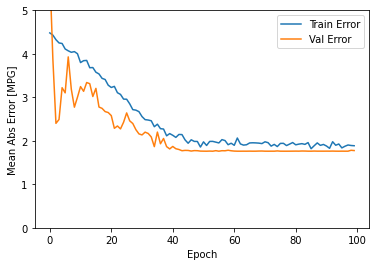

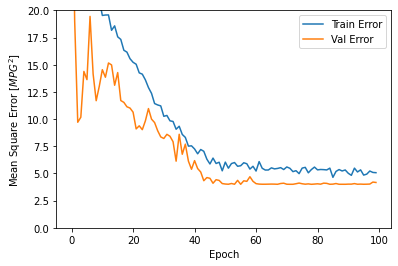

In [20]:
print(type(history_V))
print(type(history_V.history))
print(history_V.history.keys())


#モデルの訓練の様子の可視化_Valence
def plot_history(history_V):
  hist = pd.DataFrame(history_V.history)
  hist['epoch'] = history_V.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history_V)

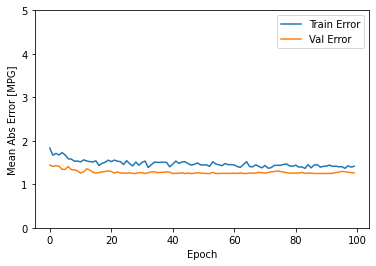

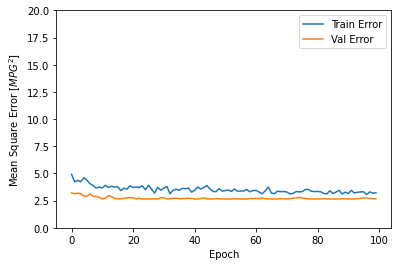

In [29]:
#モデルの訓練の様子の可視化_Arousal
def plot_history(history_A):
  hist = pd.DataFrame(history_A.history)
  hist['epoch'] = history_A.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history_A)

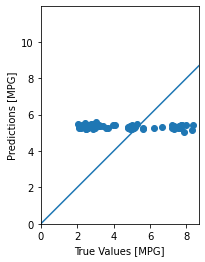

In [28]:
#テスト用ラベルで確認
#Valenceの推定

test_predictions_V = model_tuning.predict(ds_Img_test).flatten()
plt.scatter(ds_label_V_test, test_predictions_V)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


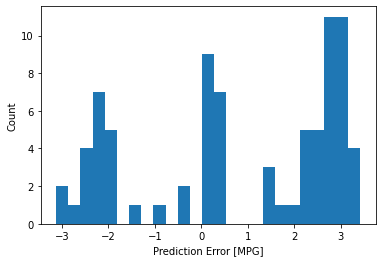

In [27]:
#Valenceの誤差分布
error_V = test_predictions_V - ds_label_V_test
plt.hist(error_V, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

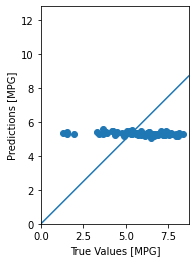

In [26]:
#テスト用ラベルで確認
#Arousalの推定
test_predictions_A = model_tuning.predict(ds_Img_test).flatten()
plt.scatter(ds_label_A_test, test_predictions_A)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

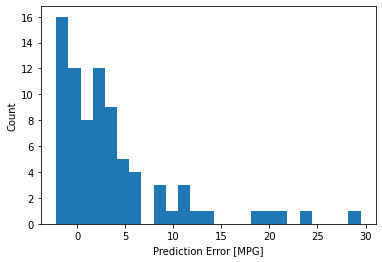

In [25]:
#Valenceの誤差分布
error_A = test_predictions_A - ds_label_A_test
plt.hist(error_A, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")